In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

data = pd.read_csv("PAX.ST.csv")

# setting our columns
data.columns=['Date', 'Close']
# converting our date column which is range  to real date
data['Date'] = pd.to_datetime(data['Date'])
#set date as index
data.set_index('Date', inplace=True) 

data = data['Close'].resample('W').mean()

# The term bfill means that we use the value before filling in missing values
data = data.fillna(data.bfill())

print(data)

Date
2017-06-18    11.700000
2017-06-25    10.500000
2017-07-02    10.500000
2017-07-09    10.400000
2017-07-16    11.350000
                ...    
2020-04-12    28.200001
2020-04-19    26.700001
2020-04-26    28.799999
2020-05-03    27.000000
2020-05-10    28.500000
Freq: W-SUN, Name: Close, Length: 152, dtype: float64


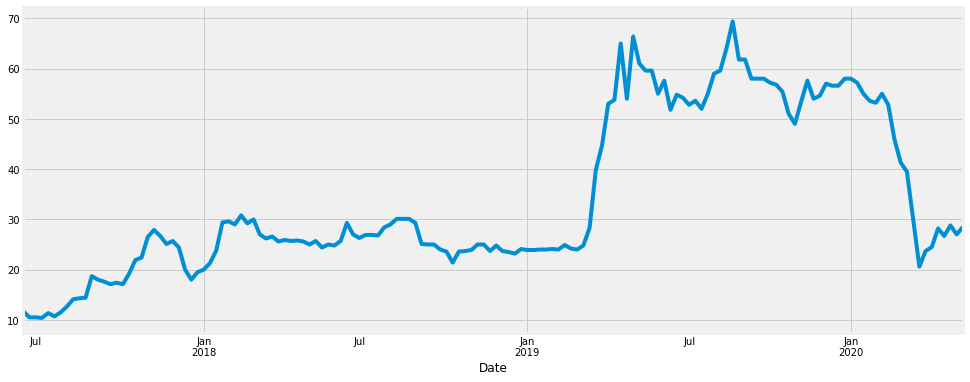

In [2]:
data.plot(figsize=(15, 6))
plt.show()

In [3]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(1, 8)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(1, 1, 1)x(1, 1, 1, 7)7 - AIC:724.3356527705945
ARIMA(1, 1, 1)x(1, 1, 2, 7)7 - AIC:692.7664714234581
ARIMA(1, 1, 1)x(1, 1, 3, 7)7 - AIC:660.4749973060146
ARIMA(1, 1, 1)x(1, 1, 4, 7)7 - AIC:627.9656410328637
ARIMA(1, 1, 1)x(1, 1, 5, 7)7 - AIC:597.4535362443766
ARIMA(1, 1, 1)x(1, 1, 6, 7)7 - AIC:4344.58245954723
ARIMA(1, 1, 1)x(1, 2, 1, 7)7 - AIC:752.2771698879213
ARIMA(1, 1, 1)x(1, 2, 2, 7)7 - AIC:684.5185019521699
ARIMA(1, 1, 1)x(1, 2, 3, 7)7 - AIC:648.5497464260006
ARIMA(1, 1, 1)x(1, 2, 4, 7)7 - AIC:617.7874858835968
ARIMA(1, 1, 1)x(1, 2, 5, 7)7 - AIC:nan
ARIMA(1, 1, 1)x(1, 2, 6, 7)7 - AIC:4055.184884260457
ARIMA(1, 1, 1)x(1, 3, 1, 7)7 - AIC:777.6451081873796
ARIMA(1, 1, 1)x(1, 3, 2, 7)7 - AIC:738.8428217357608
ARIMA(1, 1, 1)x(1, 3, 3, 7)7 - AIC:699.771109509216
ARIMA(1, 1, 1)x(1, 3, 4, 7)7 - AIC:653.0542190890137
ARIMA(1, 1, 1)x(1, 3, 5, 7)7 - AIC:nan
ARIMA(1, 1, 1)x(1, 3, 6, 7)7 - AIC:3087.804741832394
ARIMA(1, 1, 1)x(1, 4, 1, 7)7 - AIC:792.8556254750704
ARIMA(1, 1, 1)x(1, 4, 2

In [ ]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 5, 7),
                                enforce_stationarity=False,
                                 enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

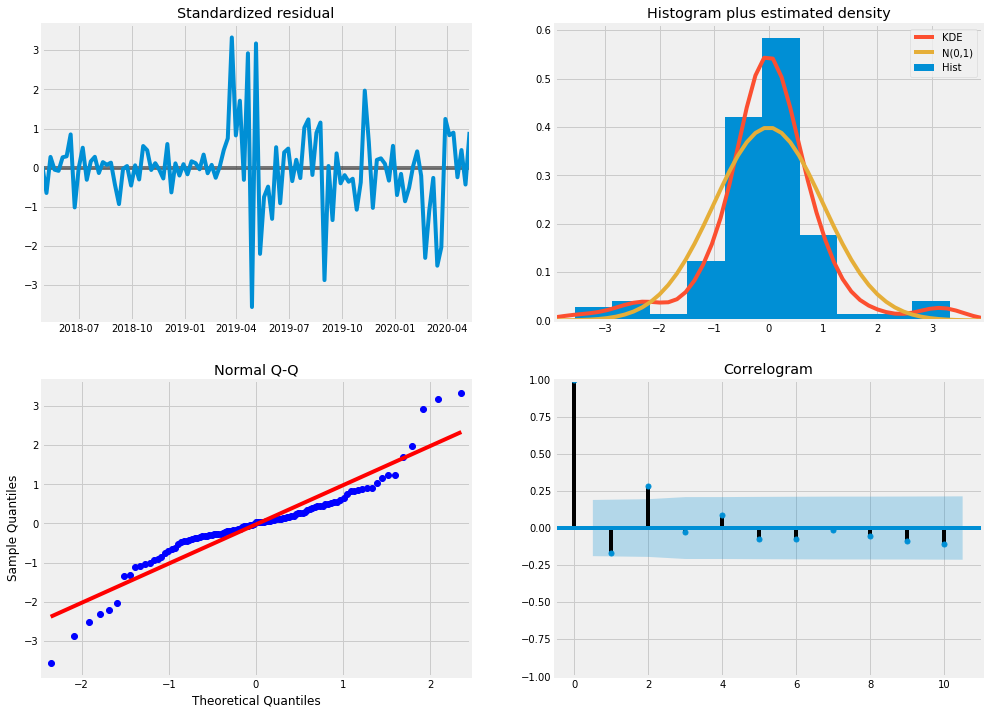

In [5]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-08-11'), dynamic=False)
pred_ci = pred.conf_int()

ax = data['2019-05-12':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Close prices')
plt.legend()

plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = data['2019-08-11':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2019-08-11'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = data['2019-05-12':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-08-12'), data.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Close prices')

plt.legend()
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = data['2019-08-11':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = data.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close prices')

plt.legend()
plt.show()